# imports

In [1]:
import pickle
from srgnn_pl import SRGNN_model, SRGNN_Map_Dataset, SRGNN_sampler
from utils import fake_parser
import torch
import os

from torch.utils.data import DataLoader
import pytorch_lightning as pl
import wandb
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import torch.utils.data as data_utils
import numpy as np

In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
import pandas as pd
import yaml


# global vars

In [40]:
dfs=[]
for k in tqdm(range(33003945//int(1e6))):
    yoo_df=pd.read_table('../datasets/yoochoose-clicks.dat', sep=',', dtype=str,
                     nrows=int(1e6), skiprows=k*int(1e6), 
                     names=['session_id','timestamp','item_id','category'])
    yoo_df=yoo_df[['item_id', 'category']].drop_duplicates()
    dfs.append(yoo_df)
items_df=pd.concat(dfs).drop_duplicates()
del dfs

100%|██████████| 33/33 [02:36<00:00,  4.74s/it]


number differs as data for paper was preprocessed to use items with >=5 occurances

In [41]:
items_df=items_df.merge(pd.DataFrame(pickle.load(open('../datasets/yoochoose_itemdict_custom_augmented.txt', 'rb')), index=[0]).T.reset_index().rename(columns={'index':'item_id', 0:'item_number'}),
             on='item_id')
items_df=items_df.loc[items_df.category.isin([str(c) for c in np.arange(1,13)])]

In [25]:
with open("./wandb/run-20240106_132434-rl90rlnq/files/config.yaml", "r") as stream:
        config=yaml.safe_load(stream)

keys=list(config.keys())
for k in keys:
    if k not in fake_parser().__dict__.keys():
        del config[k]
    else:
        config[k]=config[k]['value']

opt=fake_parser(**config)

In [26]:
#opt.nonhybrid=True
#model=SRGNN_model.load_from_checkpoint('./models/fancy-night-28/model.ckpt', opt=opt)
model=SRGNN_model.load_from_checkpoint('./GNN_master/rl90rlnq/checkpoints/epoch=2-step=55494.ckpt', opt=opt)

In [6]:
#model_dir='./srgnn_model_12_3_13_40/'
#hyperparameters=pickle.load(open(model_dir+'model_hyperparameters.txt', 'rb'))
#opt=fake_parser(*list(hyperparameters.values()))

In [22]:
test_data = pickle.load(open('../datasets/' + opt.dataset + '/test.txt', 'rb'))

#test_data = Data(test_data, shuffle=False)
# del all_train_seq, g
if opt.dataset == 'diginetica':
    n_node = 43098
elif opt.dataset == 'yoochoose1_64' or opt.dataset == 'yoochoose1_4':
    n_node = 37484

elif opt.dataset == 'yoochoose_custom':
    n_node = 28583
elif opt.dataset == 'yoochoose_custom_augmented':
    n_node = 27809
elif opt.dataset == 'yoochoose_custom_augmented_5050':
    n_node = 27807
else:
    n_node = 310



In [23]:
test_dataset=SRGNN_Map_Dataset(test_data, shuffle=False)

test_dataloader=DataLoader(test_dataset, 
                            num_workers=os.cpu_count(),  
                            sampler=SRGNN_sampler(test_dataset, opt.batchSize, shuffle=False, drop_last=False)
                            )

data masking start
data masking 1
data masking 2
data masking 3
done masking


# test

In [27]:
trainer=pl.Trainer(limit_test_batches=test_dataset.length//opt.batchSize,)
trainer.test(model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_hit          │    54.454994201660156     │
│         test_loss         │     6.112325668334961     │
│         test_mrr          │    23.760805130004883     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 6.112325668334961,
  'test_hit': 54.454994201660156,
  'test_mrr': 23.760805130004883}]

## old code for testing

In [11]:
hit, mrr = [], []
emb_avg_hit, emb_max_hit=[],[]
emb_avg_nohit, emb_max_nohit=[],[]
session_stats=[]

slices = test_data.generate_batch(model.batch_size)
for slice_i in tqdm(slices):
   # targets, scores = forward(model, i, test_data)
    
    alias_inputs, A, items, mask, targets = test_data.get_slice(slice_i)
    alias_inputs = trans_to_cuda(torch.Tensor(alias_inputs).long())
    items = trans_to_cuda(torch.Tensor(np.asarray(items)).long())
    A = trans_to_cuda(torch.Tensor(np.array(A)).float())
    mask = trans_to_cuda(torch.Tensor(mask).long())
    hidden = model(items, A)
    zero_emb=hidden[0,0]

    get = lambda i: hidden[i][alias_inputs[i]]
    get_items=lambda i: items[i][alias_inputs[i]]

    seq_hidden = torch.stack([get(i) for i in torch.arange(len(alias_inputs)).long()])
    scores = model.compute_scores(seq_hidden, mask)
    
    
    
    sub_scores = scores.topk(20)[1]
    sub_scores = trans_to_cpu(sub_scores).detach().numpy()
    for score, target, mask, session, session_emb in zip(sub_scores, targets, test_data.mask, items, seq_hidden):
        if (sum(session!=0)>1):
            single_seq=session_emb[~(session_emb==zero_emb).all(axis=1)]
            emb_dist=torch.cdist(single_seq, single_seq, p=2)
            user_distances=torch.tensor([emb_dist[i,i+1] for i in range(emb_dist.shape[0]-1)])
            
            h=np.isin(target - 1, score)
            hit.append(h)
            session_stats.append((items_df.loc[items_df.item_number.isin(session.cpu().numpy())].category.nunique(), 
                                  sum(session!=0).cpu().numpy(),
                                  h))
            if len(np.where(score == target - 1)[0]) == 0:
                mrr.append(0)
                emb_avg_nohit.append(user_distances.mean())
                emb_max_nohit.append(user_distances.max())
            else:
                mrr.append(1 / (np.where(score == target - 1)[0][0] + 1))
                emb_avg_hit.append(user_distances.mean())
                emb_max_hit.append(user_distances.max())


hit = np.mean(hit) * 100
mrr = np.mean(mrr) * 100
hit, mrr

100%|██████████| 316/316 [02:48<00:00,  1.87it/s]


(39.39361658540583, 17.49460726735838)

# analyse embeddings

In [37]:
from sklearn.decomposition import PCA

In [38]:
import plotly.graph_objects as go

## input (beore gnn)

In [44]:
def get_items_embedding(model, item_ids: torch.tensor):
    return model.model.embedding(item_ids)

In [45]:
pca=PCA(2)

fig = go.Figure()

for cat in items_df.category.unique():
    cat_df=items_df.loc[items_df.category==cat]
    item_embeddings=get_items_embedding(model, torch.tensor(cat_df.item_number.values)).detach().numpy()
    pca_item_embeddings=pca.fit_transform(item_embeddings)

    fig.add_trace(go.Scatter(x=pca_item_embeddings[:,0], y=pca_item_embeddings[:,1], name=cat, mode='markers'))




fig.update_layout(title='PCA reduced item embeddings',
                  margin=dict(l=40, r=40, t=40, b=40),
                  width=1000, height=800)
fig.show()

## run kmeans

In [47]:
from sklearn.cluster import KMeans

In [35]:
embeddings=get_items_embedding(model, torch.arange(n_node))
embeddings.shape

/tmp/ipykernel_14372/1755698452.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return model.model.embedding(torch.tensor(item_ids))


In [54]:
items_df.category.nunique()

12

In [56]:
embeddings_np=embeddings.detach().numpy()
kmeans = KMeans(n_clusters=12).fit(embeddings_np)
kmeans.cluster_centers_.shape

/home/kacper/anaconda3/envs/gpu_torch/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



(12, 128)

In [57]:
pca=PCA(2)

fig = go.Figure()


pca_item_embeddings=pca.fit_transform(embeddings_np)
fig.add_trace(go.Scatter(x=pca_item_embeddings[:,0], y=pca_item_embeddings[:,1], name='items', mode='markers'))

pca_clusters=pca.transform(kmeans.cluster_centers_)
fig.add_trace(go.Scatter(x=pca_clusters[:,0], y=pca_clusters[:,1], name='cluster center', mode='markers', marker_size=20))


fig.update_layout(title='PCA reduced item embeddings',
                  margin=dict(l=40, r=40, t=40, b=40),
                  width=1000, height=800)
fig.show()

## GNN embeddings

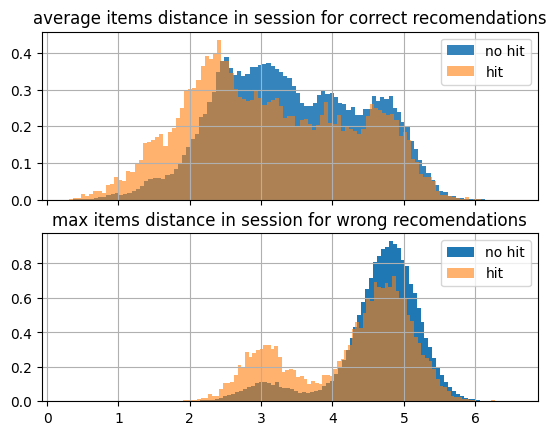

In [30]:
fig, ax = plt.subplots(2, 1, sharex=True)



ax[0].hist(emb_avg_nohit, label='no hit', alpha=0.9, cumulative=False, density=True, bins=100)
ax[0].hist(emb_avg_hit, label='hit', alpha=0.6, cumulative=False, density=True, bins=100)
ax[0].set_title('average items distance in session for correct recomendations')
ax[0].grid()
ax[0].legend()

ax[1].hist(emb_max_nohit, label='no hit', cumulative=False, density=True, bins=100)
ax[1].hist(emb_max_hit, label='hit', cumulative=False, density=True, bins=100, alpha=0.6)
ax[1].set_title('max items distance in session for wrong recomendations')
ax[1].grid()
ax[1].legend()

plt.show()

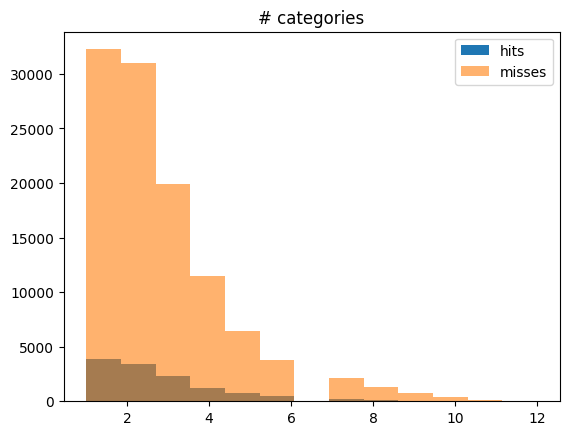

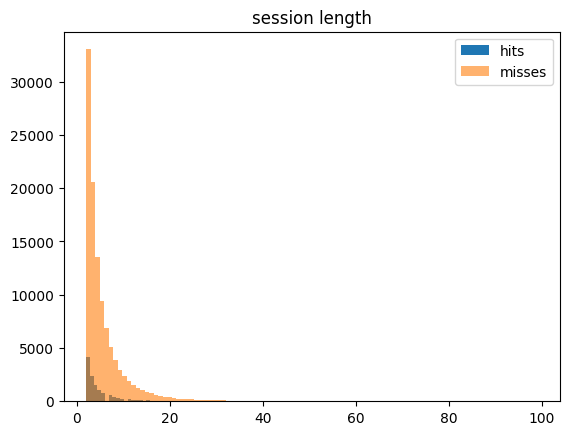

In [29]:
session_stats=np.asarray(session_stats)
hits=session_stats[:,2]==1
plt.hist(session_stats[hits, 0], label='hits', bins=13)
plt.hist(session_stats[~hits, 0], label='misses', alpha=0.6, bins=13)
plt.title('# categories')
plt.legend()
plt.show()

plt.hist(session_stats[hits, 1], label='hits', bins=100)
plt.hist(session_stats[~hits, 1], label='misses', alpha=0.6, bins=100)
plt.title('session length')
plt.legend()
plt.show()